In [150]:
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
import hvplot

import datetime
from datetime import date, timedelta
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
%matplotlib inline

load_dotenv()

True

In [151]:
def fetch_data():
    """Fetches the latest prices."""
   # Set Alpaca API key and secret

    alpaca_api_key = os.getenv("ALPACA_API_KEY")
    alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
    
    alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")
    today = date.today()
    start = date.today() - timedelta(days=120)

    # Set the tickers & timeframe
    tickers = ["SPY"]

    timeframe = "15Min"

    #Get Closing prices for past 60 days

    df = alpaca.get_barset(
        tickers,
        timeframe,
        start = start,
        end = today
    ).df
    #figure out another way to clean and prep the data here - hard coded for now 
    df_clean = df['SPY']

    # Display sample data
    return df_clean

In [152]:
data = fetch_data()
data = data.reset_index()
data = data.set_index('time', drop=True)
data['close of tomorrow'] = data['close'].shift(-1)
data

,open,high,low,close,volume,close of tomorrow
time,,,,,,
2021-03-16 10:30:00-04:00,397.630,397.830,397.460,397.510,29972,397.450
2021-03-16 10:45:00-04:00,397.470,397.795,397.290,397.450,14948,397.195
2021-03-16 11:00:00-04:00,397.295,397.370,397.015,397.195,30948,397.220
2021-03-16 11:15:00-04:00,397.240,397.460,397.170,397.220,24916,397.000
2021-03-16 11:30:00-04:00,397.320,397.420,396.930,397.000,12524,397.030
...,...,...,...,...,...,...
2021-03-19 14:45:00-04:00,391.035,391.335,390.670,391.325,23458,390.780
2021-03-19 15:00:00-04:00,391.450,391.550,390.775,390.780,35664,390.790
2021-03-19 15:15:00-04:00,390.770,390.920,390.505,390.790,32383,391.025


In [153]:
# Drop Null values -- can cause error 
data.dropna(inplace=True)
data

,open,high,low,close,volume,close of tomorrow
time,,,,,,
2021-03-16 10:30:00-04:00,397.630,397.830,397.460,397.510,29972,397.450
2021-03-16 10:45:00-04:00,397.470,397.795,397.290,397.450,14948,397.195
2021-03-16 11:00:00-04:00,397.295,397.370,397.015,397.195,30948,397.220
2021-03-16 11:15:00-04:00,397.240,397.460,397.170,397.220,24916,397.000
2021-03-16 11:30:00-04:00,397.320,397.420,396.930,397.000,12524,397.030
...,...,...,...,...,...,...
2021-03-19 14:30:00-04:00,390.905,391.075,390.760,390.970,33881,391.325
2021-03-19 14:45:00-04:00,391.035,391.335,390.670,391.325,23458,390.780
2021-03-19 15:00:00-04:00,391.450,391.550,390.775,390.780,35664,390.790


In [154]:
#define feauture and target values
X = data[['open', 'high', 'low', 'close', 'volume']]
y = data[['close of tomorrow']]


X = np.array(X)
y = np.array(y)

In [155]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [156]:
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()
X_scaler = scaler.fit(X)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
y_scaler = scaler.fit(y)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [157]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.99113198]
  [0.97080292]
  [1.        ]
  [0.98039216]
  [0.13851052]]

 [[0.97443923]
  [0.96715328]
  [0.98350315]
  [0.97403286]
  [0.04859598]]

 [[0.95618153]
  [0.92283629]
  [0.95681708]
  [0.94700583]
  [0.14435161]]] 

X_test sample values:
[[[0.47157016]
  [0.53441084]
  [0.53323629]
  [0.53948066]
  [0.29301822]]

 [[0.53729786]
  [0.51876955]
  [0.50703542]
  [0.5108638 ]
  [0.18592153]]

 [[0.50182577]
  [0.46506778]
  [0.46821931]
  [0.48012719]
  [0.21939411]]]


In [158]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [159]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=90, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=45))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [160]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [161]:
# Show the model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 5, 30)             3840      
_________________________________________________________________
dropout_12 (Dropout)         (None, 5, 30)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 5, 90)             43560     
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 90)             0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 45)                24480     
_________________________________________________________________
dropout_14 (Dropout)         (None, 45)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [162]:
# Train the model
model.fit(X_train, y_train, epochs=100, shuffle=False, batch_size=90, verbose=1)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.6036
Epoch 2/100
1/1 [==============================] - 0s 13ms/step - loss: 0.5663
Epoch 3/100
1/1 [==============================] - 0s 10ms/step - loss: 0.5226
Epoch 4/100
1/1 [==============================] - 0s 11ms/step - loss: 0.4841
Epoch 5/100
1/1 [==============================] - 0s 10ms/step - loss: 0.4403
Epoch 6/100
1/1 [==============================] - 0s 13ms/step - loss: 0.3946
Epoch 7/100
1/1 [==============================] - 0s 11ms/step - loss: 0.3497
Epoch 8/100
1/1 [==============================] - 0s 19ms/step - loss: 0.3008
Epoch 9/100
1/1 [==============================] - 0s 12ms/step - loss: 0.2490
Epoch 10/100
1/1 [==============================] - 0s 14ms/step - loss: 0.1965
Epoch 11/100
1/1 [==============================] - 0s 12ms/step - loss: 0.1513
Epoch 12/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0994
Epoch 13/100
1/1 [==============================] -

In [163]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)


1/1 [==============================] - 1s 1s/step - loss: 0.0643


0.06429779529571533

In [165]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)
trained_predicted = model.predict(X_train)
print(predicted)
print(trained_predicted)

[[0.61948067]
 [0.62322766]
 [0.60022503]
 [0.58969635]
 [0.544496  ]
 [0.40749574]
 [0.3385732 ]
 [0.33306795]
 [0.3461087 ]
 [0.36749172]
 [0.40557355]
 [0.41717926]
 [0.38887888]
 [0.39744768]
 [0.453821  ]
 [0.47009447]
 [0.46916798]
 [0.47352406]
 [0.4881414 ]
 [0.4820081 ]
 [0.47893694]
 [0.49188572]
 [0.5000312 ]
 [0.497876  ]
 [0.47547823]
 [0.49059546]
 [0.4980763 ]
 [0.510484  ]
 [0.48029086]
 [0.49337965]]
[[0.88976467]
 [0.88081104]
 [0.8670143 ]
 [0.8683324 ]
 [0.86316866]
 [0.849814  ]
 [0.8495373 ]
 [0.824201  ]
 [0.8270179 ]
 [0.83958685]
 [0.85184014]
 [0.855504  ]
 [0.8346034 ]
 [0.8062706 ]
 [0.8118316 ]
 [0.79745936]
 [0.7586533 ]
 [0.76572233]
 [0.7923613 ]
 [0.81017995]
 [0.81975853]
 [0.8134032 ]
 [0.70124567]
 [0.7091403 ]
 [0.7009064 ]
 [0.7098276 ]
 [0.69321203]
 [0.64822334]
 [0.6547114 ]
 [0.6686689 ]
 [0.6746629 ]
 [0.67849386]
 [0.6844448 ]
 [0.7019313 ]
 [0.6870512 ]
 [0.6727004 ]
 [0.66893816]
 [0.67837   ]
 [0.6820792 ]
 [0.67629856]
 [0.7594726 ]
 [0.8

In [166]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
train_predicted_prices = scaler.inverse_transform(trained_predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
train_real_prices = scaler.inverse_transform(y_train.reshape(-1,1))

In [167]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = data.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.tail()

,Actual,Predicted
time,,
2021-03-19 14:30:00-04:00,391.325,392.888763
2021-03-19 14:45:00-04:00,390.780,392.959351
2021-03-19 15:00:00-04:00,390.790,393.076416
2021-03-19 15:15:00-04:00,391.025,392.791534
2021-03-19 15:30:00-04:00,389.480,392.915039


In [175]:
# Create another DataFrame of trained Real and Predicted values
trained_stocks = pd.DataFrame({
    "Actual": train_real_prices.ravel(),
    "Predicted": train_predicted_prices.ravel()
}, index = data.index[-len(train_real_prices): ]) 

# Show the DataFrame's head
trained_stocks.tail()

,Actual,Predicted
time,,
2021-03-19 14:30:00-04:00,396.060,395.545532
2021-03-19 14:45:00-04:00,395.120,395.699524
2021-03-19 15:00:00-04:00,393.935,395.603516
2021-03-19 15:15:00-04:00,392.680,395.059082
2021-03-19 15:30:00-04:00,393.350,394.429749


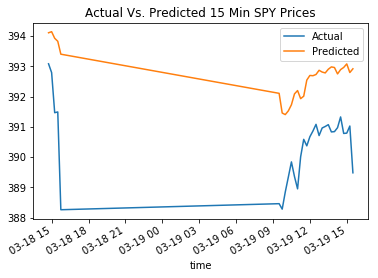

In [176]:
# Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted 15 Min SPY Prices")

In [182]:
data2 = data
data2

,open,high,low,close,volume,close of tomorrow,Predicted
time,,,,,,,
2021-03-16 10:30:00-04:00,397.630,397.830,397.460,397.510,29972,397.450,NaN
2021-03-16 10:45:00-04:00,397.470,397.795,397.290,397.450,14948,397.195,NaN
2021-03-16 11:00:00-04:00,397.295,397.370,397.015,397.195,30948,397.220,NaN
2021-03-16 11:15:00-04:00,397.240,397.460,397.170,397.220,24916,397.000,NaN
2021-03-16 11:30:00-04:00,397.320,397.420,396.930,397.000,12524,397.030,NaN
...,...,...,...,...,...,...,...
2021-03-19 14:30:00-04:00,390.905,391.075,390.760,390.970,33881,391.325,392.888763
2021-03-19 14:45:00-04:00,391.035,391.335,390.670,391.325,23458,390.780,392.959351
2021-03-19 15:00:00-04:00,391.450,391.550,390.775,390.780,35664,390.790,393.076416


In [192]:
combined_stocks_df = pd.concat([stocks, trained_stocks])
combined_stocks_df.reset_index(inplace=True)
#combined_stocks_df
data2.reset_index(inplace = True)

data2['Predicted'] = combined_stocks_df['Predicted']


In [193]:
#combined_stocks_df[combined_stocks_df.index.duplicated()]


In [195]:
#data2.dropna(inplace=True)
data2.set_index('time')


,open,high,low,close,volume,close of tomorrow,Predicted
time,,,,,,,
2021-03-16 10:30:00-04:00,397.630,397.830,397.460,397.510,29972,397.450,394.104828
2021-03-16 10:45:00-04:00,397.470,397.795,397.290,397.450,14948,397.195,394.140167
2021-03-16 11:00:00-04:00,397.295,397.370,397.015,397.195,30948,397.220,393.923126
2021-03-16 11:15:00-04:00,397.240,397.460,397.170,397.220,24916,397.000,393.823792
2021-03-16 11:30:00-04:00,397.320,397.420,396.930,397.000,12524,397.030,393.397339
...,...,...,...,...,...,...,...
2021-03-19 14:30:00-04:00,390.905,391.075,390.760,390.970,33881,391.325,395.545532
2021-03-19 14:45:00-04:00,391.035,391.335,390.670,391.325,23458,390.780,395.699524
2021-03-19 15:00:00-04:00,391.450,391.550,390.775,390.780,35664,390.790,395.603516


In [196]:
data2['Difference'] = abs(data2['close of tomorrow'] - data2['Predicted'])
data2['Avg off'] = data2['Difference'].mean()
data2.tail()

,time,open,high,low,close,volume,close of tomorrow,Predicted,Difference,Avg off
94,2021-03-19 14:30:00-04:00,390.905,391.075,390.760,390.970,33881,391.325,395.545532,4.220532,3.008182
95,2021-03-19 14:45:00-04:00,391.035,391.335,390.670,391.325,23458,390.780,395.699524,4.919524,3.008182
96,2021-03-19 15:00:00-04:00,391.450,391.550,390.775,390.780,35664,390.790,395.603516,4.813516,3.008182
97,2021-03-19 15:15:00-04:00,390.770,390.920,390.505,390.790,32383,391.025,395.059082,4.034082,3.008182
98,2021-03-19 15:30:00-04:00,390.825,391.325,390.600,391.025,44051,389.480,394.429749,4.949749,3.008182


In [197]:
#Lets create a new data frame that records if we should buy or sell based the price of tomorrow's close price
#We will create a column for predicting the price moved up or down Call/Put -- Call = 1 Put = 0
#Using Open, High, Low, Close and Volume here but considered pulling in data from Alphavantage and include more data as parameters -- train both multiple classification models and determine which is best 
#Consider training Random Forrest Model to predict call or put - taraget will be call/put - features can be all data than can be pulled except close of tomorrow and predicted
signals_df = data2.drop(columns=['Difference', 'Avg off'])
signals_df['Call/Put'] = np.where(signals_df['close'] < signals_df['close of tomorrow'], 1, 0)
signals_df


,time,open,high,low,close,volume,close of tomorrow,Predicted,Call/Put
0,2021-03-16 10:30:00-04:00,397.630,397.830,397.460,397.510,29972,397.450,394.104828,0
1,2021-03-16 10:45:00-04:00,397.470,397.795,397.290,397.450,14948,397.195,394.140167,0
2,2021-03-16 11:00:00-04:00,397.295,397.370,397.015,397.195,30948,397.220,393.923126,1
3,2021-03-16 11:15:00-04:00,397.240,397.460,397.170,397.220,24916,397.000,393.823792,0
4,2021-03-16 11:30:00-04:00,397.320,397.420,396.930,397.000,12524,397.030,393.397339,1
...,...,...,...,...,...,...,...,...,...
94,2021-03-19 14:30:00-04:00,390.905,391.075,390.760,390.970,33881,391.325,395.545532,1
95,2021-03-19 14:45:00-04:00,391.035,391.335,390.670,391.325,23458,390.780,395.699524,0
96,2021-03-19 15:00:00-04:00,391.450,391.550,390.775,390.780,35664,390.790,395.603516,1
97,2021-03-19 15:15:00-04:00,390.770,390.920,390.505,390.790,32383,391.025,395.059082,1


In [198]:
#define feauture and target values
X2 = signals_df[['open', 'high', 'low', 'close', 'volume']]
y2 = signals_df[['Call/Put']]

X2 = np.array(X2)
y2 = np.array(y2)

# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X2))
X_train = X2[: split]
X_test = X2[split:]
y_train = y2[: split]
y_test = y2[split:]

In [199]:
signals_df

,time,open,high,low,close,volume,close of tomorrow,Predicted,Call/Put
0,2021-03-16 10:30:00-04:00,397.630,397.830,397.460,397.510,29972,397.450,394.104828,0
1,2021-03-16 10:45:00-04:00,397.470,397.795,397.290,397.450,14948,397.195,394.140167,0
2,2021-03-16 11:00:00-04:00,397.295,397.370,397.015,397.195,30948,397.220,393.923126,1
3,2021-03-16 11:15:00-04:00,397.240,397.460,397.170,397.220,24916,397.000,393.823792,0
4,2021-03-16 11:30:00-04:00,397.320,397.420,396.930,397.000,12524,397.030,393.397339,1
...,...,...,...,...,...,...,...,...,...
94,2021-03-19 14:30:00-04:00,390.905,391.075,390.760,390.970,33881,391.325,395.545532,1
95,2021-03-19 14:45:00-04:00,391.035,391.335,390.670,391.325,23458,390.780,395.699524,0
96,2021-03-19 15:00:00-04:00,391.450,391.550,390.775,390.780,35664,390.790,395.603516,1
97,2021-03-19 15:15:00-04:00,390.770,390.920,390.505,390.790,32383,391.025,395.059082,1


In [200]:
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
#X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_test

array([[0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0]])

In [201]:
from sklearn.ensemble import RandomForestClassifier
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = pd.DataFrame({'results': y_test.ravel()})

Results["Predicted Value"] = predictions
Results

C:\Users\jacob\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


,results,Predicted Value
0,0,1
1,0,1
2,0,1
3,1,1
4,0,1
5,1,1
6,0,1
7,1,1
8,1,1
9,1,1


In [203]:
#evaulute model performance 
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)


#print(classification_report(y_test, y_pred))

array([[ 0, 12],
       [ 0, 18]], dtype=int64)